          f1_25     f1_50     f1_75
group                              
High   0.120717  0.219577  0.296055
Low    0.039134  0.088513  0.140941


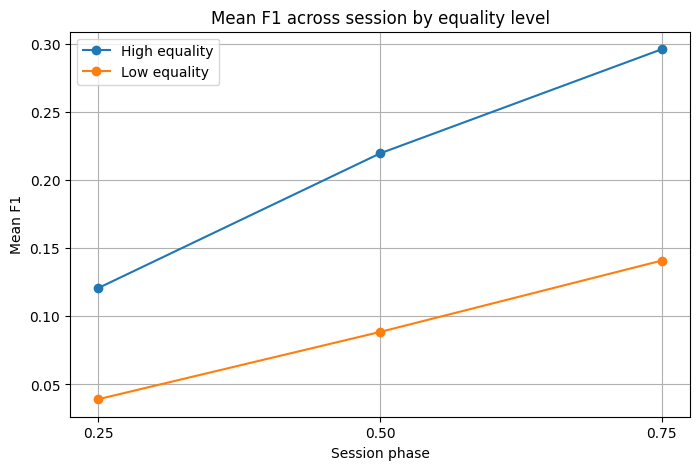

f1_25 → t=3.509, p=0.0014
f1_50 → t=4.450, p=0.0001
f1_75 → t=4.470, p=0.0001


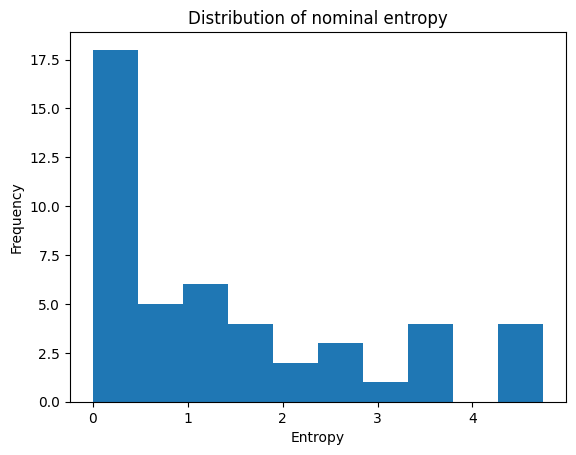

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# 1. Load files
df25 = pd.read_csv("/content/drive/MyDrive/acdt2학기/results_0.25.csv")
df50 = pd.read_csv("/content/drive/MyDrive/acdt2학기/results_0.5.csv")
df75 = pd.read_csv("/content/drive/MyDrive/acdt2학기/results_0.75.csv")
df_nom = pd.read_csv("/content/drive/MyDrive/acdt2학기/results_nominal.csv")

# 2. Basic merge (team-level data)
df25 = df25.groupby("instanceId")["g_f1"].mean().reset_index().rename(columns={"g_f1":"f1_25"})
df50 = df50.groupby("instanceId")["g_f1"].mean().reset_index().rename(columns={"g_f1":"f1_50"})
df75 = df75.groupby("instanceId")["g_f1"].mean().reset_index().rename(columns={"g_f1":"f1_75"})
df_nom = df_nom.groupby("instanceId")["g_effortEntropy"].mean().reset_index().rename(columns={"g_effortEntropy":"entropy"})

merged = df25.merge(df50, on="instanceId").merge(df75, on="instanceId").merge(df_nom, on="instanceId")

# 3. Split by median entropy
median_value = merged["entropy"].median()
merged["group"] = np.where(merged["entropy"] >= median_value, "High", "Low")

# 4. Calculate means for each group
group_mean = merged.groupby("group")[["f1_25","f1_50","f1_75"]].mean()
print(group_mean)

# 5. Plot
plt.figure(figsize=(8,5))
plt.plot(["0.25","0.50","0.75"], group_mean.loc["High"], marker='o', label="High equality")
plt.plot(["0.25","0.50","0.75"], group_mean.loc["Low"], marker='o', label="Low equality")
plt.title("Mean F1 across session by equality level")
plt.xlabel("Session phase")
plt.ylabel("Mean F1")
plt.legend()
plt.grid(True)
plt.show()

# 6. Independent t-tests for each session
for phase in ["f1_25","f1_50","f1_75"]:
    high = merged.loc[merged["group"]=="High", phase]
    low = merged.loc[merged["group"]=="Low", phase]
    t, p = stats.ttest_ind(high, low, equal_var=False)
    print(f"{phase} → t={t:.3f}, p={p:.4f}")

# 7. Simple histogram
plt.hist(merged["entropy"], bins=10)
plt.title("Distribution of nominal entropy")
plt.xlabel("Entropy")
plt.ylabel("Frequency")
plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
from scipy import stats

# 1. Load data
df25 = pd.read_csv("/content/drive/MyDrive/acdt2학기/results_0.25.csv")
df50 = pd.read_csv("/content/drive/MyDrive/acdt2학기/results_0.5.csv")
df75 = pd.read_csv("/content/drive/MyDrive/acdt2학기/results_0.75.csv")
df_nom = pd.read_csv("/content/drive/MyDrive/acdt2학기/results_nominal.csv")

# 2. Identify necessary columns
group_id = "instanceId"
entropy_col = "g_effortEntropy"
chat_col = "g_chatFrac" if "g_chatFrac" in df_nom.columns else "g_chatWeight"

# 3. Compute team-level age variance
df_people = pd.concat([df25[[group_id,"age"]], df50[[group_id,"age"]], df75[[group_id,"age"]]])
df_people = df_people.dropna(subset=["age"])
age_var = df_people.groupby(group_id)["age"].var().reset_index().rename(columns={"age":"age_var"})

# 4. Merge with nominal data
df = df_nom.merge(age_var, on=group_id, how="left")

# 5. Split teams by median g_f1
median_f1 = df["g_f1"].median()
df["group"] = np.where(df["g_f1"] >= median_f1, "High", "Low")

# 6. Frequency table (simple version)
f1_series = df["g_f1"].dropna()
bins = np.linspace(f1_series.min(), f1_series.max(), 8)
counts, edges = np.histogram(f1_series, bins=bins)
freq_table = pd.DataFrame({"Left":edges[:-1],"Right":edges[1:],"Count":counts})
print(freq_table)

# 7. Welch t-tests for the four variables
for col in ["g_fracFemale","age_var",entropy_col,chat_col]:
    high = df.loc[df["group"]=="High", col].dropna()
    low = df.loc[df["group"]=="Low", col].dropna()
    t, p = stats.ttest_ind(high, low, equal_var=False)
    print(f"{col} → t={t:.3f}, p={p:.4f}")

       Left     Right  Count
0  0.034483  0.119619     16
1  0.119619  0.204755     11
2  0.204755  0.289891     33
3  0.289891  0.375027     49
4  0.375027  0.460163     59
5  0.460163  0.545299     32
6  0.545299  0.630435     77
g_fracFemale → t=-3.077, p=0.0025
age_var → t=3.838, p=0.0002
g_effortEntropy → t=17.488, p=0.0000
g_chatFrac → t=7.804, p=0.0000
